In [1]:
import configparser
import pymorphy2
import psycopg2
import pandas as pd
import numpy as np
import string
import nltk
import wordcloud
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

from tqdm import tqdm, tqdm_notebook
from typing import List

import warnings 
warnings.simplefilter("ignore")

## Выборка даннных

In [2]:
config = configparser.ConfigParser()
config.read('config.cfg')

DB_AUTH = {key: config['DB'][key] for key in config['DB']}

In [4]:
conn = psycopg2.connect(**DB_AUTH)
query = """SELECT * FROM vacancies;"""
vacancies = pd.read_sql(query, conn)

In [5]:
vacancies.head()

,id,vacancy,company,experience,salary,url,description,skills,date,keyword,address
0,42603472,Старший специалист по продажам малому и средне...,Билайн,1,NaN,https://irkutsk.hh.ru/vacancy/42603472,Наша команда B2B всегда готова предложить клие...,"[B2B Продажи, Холодные продажи, Проведение пре...",2021-03-24,data+analyst,Иркутск
1,43029741,Старший специалист по продажам малому и средне...,Билайн,1,NaN,https://khabarovsk.hh.ru/vacancy/43029741,Наша команда B2B всегда готова предложить клие...,"[B2B Продажи, Холодные продажи, Проведение пре...",2021-03-24,data+analyst,Хабаровск
2,43652032,Salesforce аналитик,Apple Concierge,1,NaN,https://hh.ru/vacancy/43652032,Мы приглашаем к нам в команду Salesforce анали...,"[MS Outlook, Английский язык, MS PowerPoint, C...",2021-04-13,data+analyst,"Щукинская, Москва, Таганско-Краснопресненская ..."
3,43822457,Data Analyst,ООО Chatfuel,1,4000.0,https://hh.ru/vacancy/43822457,"Мы — Chatfuel, самая крупная платформа для соз...","[Английский — B2 — Средне-продвинутый, Python,...",2021-04-12,data+analyst,Москва
4,43356258,Junior data analyst,Сбер для экспертов,1,NaN,https://hh.ru/vacancy/43356258,"Функции: Разработка и мониторинг показателей,...","[Python, SQL, Управление рисками, Анализ данны...",2021-03-25,data+analyst,Москва


Описание некоторых вакансий дублируются.

In [6]:
vacancies.description.duplicated().sum()

728

In [7]:
df = vacancies.sort_values('date', ascending=False) \
              .drop_duplicates(subset='description', keep='first')

Потребуются только описательные данные: название вакансии, описание и требования к компетенции.

In [8]:
data = df['vacancy'] + ' ' + df['description'] + ' ' + df['skills'].apply(' '.join)

## Предобработка данных

In [9]:
class PrepareMachine:

    def __init__(self, data):
        self.data = data
        
        
    def tokenize(self, reg):
        tqdm.pandas(desc=f'{"tokenize":<22}')
        #self.data = self.data.progress_apply(lambda s: s.lower())
        tokenizer = nltk.tokenize.RegexpTokenizer(reg)
        self.data = self.data.progress_apply(lambda s: tokenizer.tokenize(s.lower()))
        return self.data
    
    
    def remove_numbers(self):
        tqdm.pandas(desc=f'{"remove numbers":<22}')
        del_num = lambda s: [w for w in s if not w.isdigit()]
        self.data = self.data.progress_apply(del_num)
        return self.data
    
    
    def remove_stop_words(self, stop_words):
        tqdm.pandas(desc=f'{f"remove stop words {len(stop_words)}":<22}')
        del_stop_words = lambda s: [w for w in s if w not in stop_words]
        self.data = self.data.progress_apply(del_stop_words)
        return self.data

    
    def remove_1char_words(self):
        tqdm.pandas(desc=f'{"remove 1 char words":<22}')
        del_1char_words = lambda s: [w for w in s if len(w) > 1 or w in ('r', 'c')]
        self.data = self.data.progress_apply(del_1char_words)
        return self.data
    
    
    def lemmatizing(self):
        tqdm.pandas(desc=f'{"lemmatizing":<22}')
        lemmatizer = nltk.stem.WordNetLemmatizer()

        lemm = lambda s: [lemmatizer.lemmatize(w) for w in s]
        self.data = self.data.progress_apply(lemm)
        return self.data

    
    def stemming(self):
        stemmer = nltk.stem.porter.PorterStemmer()

        def stemm(s):
            return [stemmer.stem(w) for w in s]
        
        self.data = self.data.apply(stemm)
        return self.data
    
    
    def normalization(self):
        tqdm.pandas(desc=f'{"normalization":<22}')
        morph = pymorphy2.MorphAnalyzer()
        get_normal_forms = lambda s: [morph.parse(w)[0].normal_form for w in s]
        self.data = self.data.progress_apply(get_normal_forms)
        return self.data
     
    
    def remove_hapaxes(self):
        tqdm.pandas(desc=f'{"remove hapaxes":<22}')
        hapaxes = nltk.FreqDist(self.data.apply(' '.join).str.cat().split()).hapaxes()
        del_hapaxes = lambda s: [w for w in s if w not in hapaxes]
        self.data = self.data.progress_apply(del_hapaxes)
        return self.data
    
    
    def default_pipeline(self, to_replace=None, to_regular=None,
                         token_reg=None, short_words='lemm'):
        if short_words != 'lemm' and short_words != 'stemm':
            raise Exeption(f'Unknown tool: {short_words}')
        print('Removing patterns...')
        self.remove_pattern(to_replace=to_replace, to_regular=to_regular)
        print('Removing punctuation...')
        self.remove_punctuation()
        print('Removing numbers...')
        self.remove_numbers()
        print('Tokenizing...')
        self.tokenize(reg=token_reg)
        print('Removing stop words...')
        self.remove_stop_words()
        if short_words == 'stemm':
            print('Stemming...')
            self.stemming()
        else:
            print('Lemmatizing...')
            self.lemmatizing()
        print('Done!')
        return self.data

### Стоп-слова

In [10]:
with open('manual_stop_words.txt', 'r') as fh:
    manual_stop_words = fh.read().split()

In [11]:
prep = PrepareMachine(data)

### Пайплайн трансформации текстового набора

In [12]:
prep.tokenize(reg=r'\w+')
prep.remove_numbers()
prep.remove_stop_words(nltk.corpus.stopwords.words('russian'))
prep.remove_stop_words(nltk.corpus.stopwords.words('english'))
prep.normalization()
prep.lemmatizing()
prep.remove_stop_words(manual_stop_words)
prepared_data = prep.remove_hapaxes()

remove hapaxes        : 100%|██████████| 3473/3473 [03:32<00:00, 16.32it/s]


###  Частотность каждой лексеммы

In [16]:
counts = nltk.FreqDist(sum(prepared_data, []))

### Визуализация в виде облака 100 самых популярных терминов

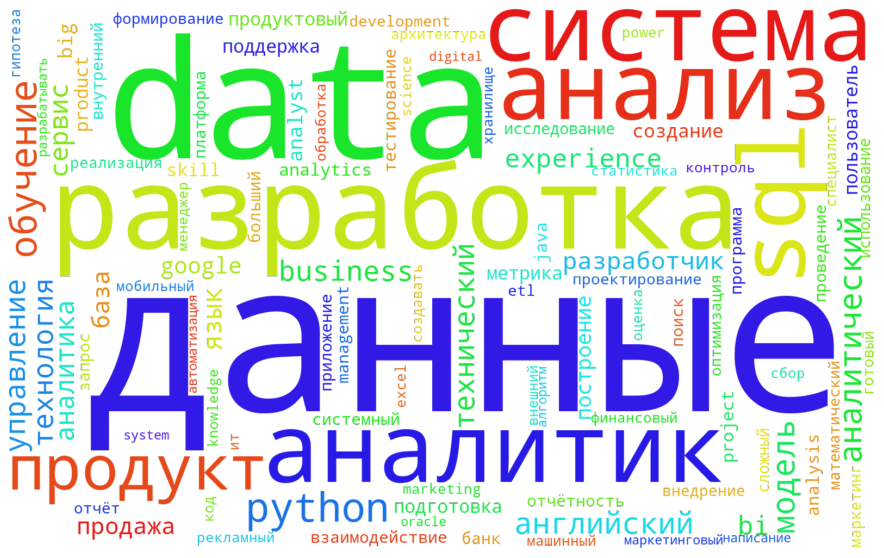

In [70]:
cloud = wordcloud.WordCloud(
    width=1600, height=1000, mode="RGBA", background_color=None, 
    max_words=100, relative_scaling=1,
    color_func=wordcloud.random_color_func,
    prefer_horizontal=.5,
    normalize_plurals=False)
cloud.generate_from_frequencies(counts)

plt.figure(figsize=(16,10))
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off');

## Векторная модель данных

In [81]:
w2v = Word2Vec(size=200, window=5, min_count=5)
w2v.build_vocab(prepared_data)

In [82]:
words = w2v.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 7305


In [83]:
%%time
w2v.train(prepared_data, total_examples=len(prepared_data), epochs=100)

CPU times: user 2min 36s, sys: 3.14 s, total: 2min 39s
Wall time: 1min 13s


(36522876, 42550800)

In [107]:
index2word_set = set(w2v.wv.index2word)

def feature_vec(words, model, num_features):
    feat_vec = np.zeros(num_features, dtype="float32")
    nwords = 0
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1
            feat_vec = np.add(feat_vec, model[word])
    feat_vec = np.divide(feat_vec, nwords)
    return feat_vec

In [121]:
encoded_data = []
for line in prepared_data:
    encoded_data.append(feature_vec(words=line, model=w2v, num_features=w2v.vector_size))

In [132]:
encoded_data = np.array(encoded_data)#.reshape(-1, 1)

### Вариант №2

In [44]:
# в новой версии параметры vector_size=200, epochs=30
w2v = Word2Vec(sentences=prepared_data, size=200, window=7, min_count=5, iter=50)

In [53]:
def average_embedding(texts: List[List[float]], embedder: Word2Vec) -> List[List[float]]:
    '''
    texts -- вложенный список токенов (каждый вложенный список соответствует тексту)
    embedder -- объект с полем wv, у которого определен оператор [], и с полем vector_size
    return: матрица усредненных эмбеддингов
    '''
    embedding_matrix = []
    size = w2v.vector_size
    for text in texts:
        embedding = np.zeros(size)
        for word in text:
            try:
                vec = embedder.wv.get_vector(word)
            except KeyError:
                vec = np.zeros(size)
            embedding += vec
        embedding_matrix.append(embedding / len(text))
    return np.array(embedding_matrix)

### Матрица усредненных эмбеддингов

In [54]:
w2v_enc = average_embedding(prepared_data, w2v)

In [92]:
all_terms = [x[0] for x in counts.most_common(10)]
similar_words = {}
for term in [x for x, y in counts.most_common(10)]:
    terms = []
    for item in w2v.wv.most_similar([term], topn=6):
        
        if item[0] not in all_terms:
            all_terms.append(item[0])
            terms.append(item[0])
        similar_words[term] = terms

### t-distributed Stochastic Neighbor Embedding

Алгоритм машинного обучения для визуализации, разработанный Лоренсом ван дер Маатеном и Джеффри Хинтоном. Он является техникой нелинейного снижения размерности, хорошо подходящей для вложения данных высокой размерности для визуализации в пространство низкой размерности (двух- или трехмерное). В частности, метод моделирует каждый объект высокой размерности двух- или трёхмерной точкой таким образом, что похожие объекты моделируются близко расположенными точками, а непохожие точки моделируются с большой вероятностью точками, далеко друг от друга отстоящими. [Wiki](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B2%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9_%D1%81_t-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC)

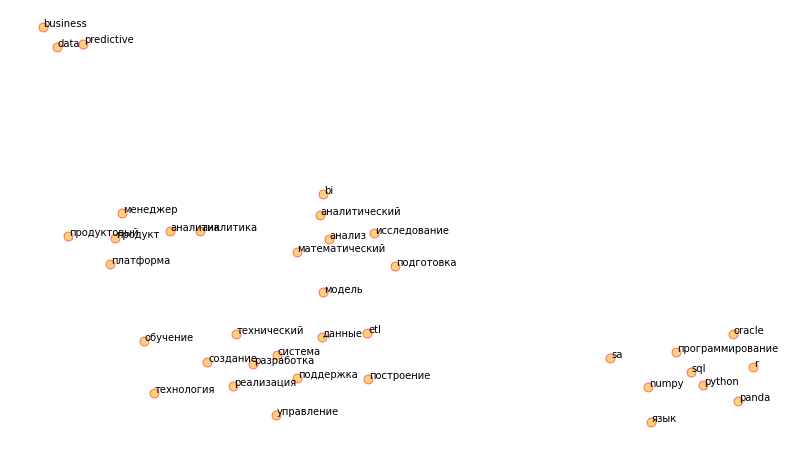

In [93]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))

plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r', s=80, alpha=.5)
plt.axis('off')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Кластеризация
### Выбор оптимального количества кластеров методом «локтя»

In [94]:
# The Elbow Method
# Within-Cluster-Sum of Squared Errors (WSS)
def calculate_wss(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters=k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse

In [133]:
wss = calculate_wss(encoded_data, 15)

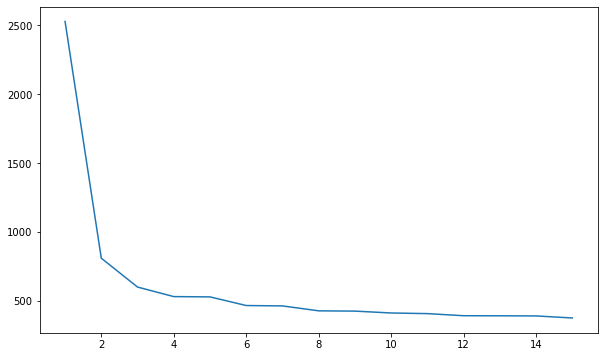

In [134]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 16), y=wss);

График преломляется в точках 3 и 8.

### Метод силуэта

In [135]:
sil = []
kmax = 15

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(w2v_enc)
    labels = kmeans.labels_
    sil.append(silhouette_score(encoded_data, labels, metric='euclidean'))

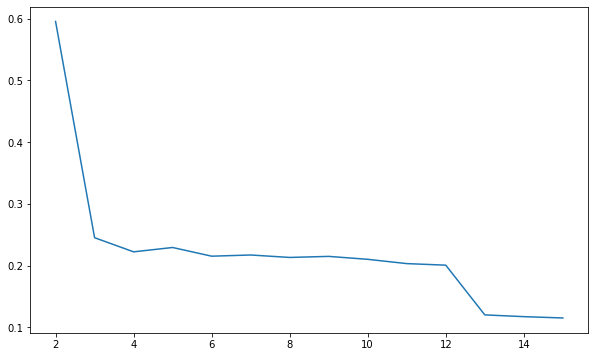

In [136]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(2, 16), y=sil);

Максимальные значения в области [3, 12].

### Иерархическая кластирезация

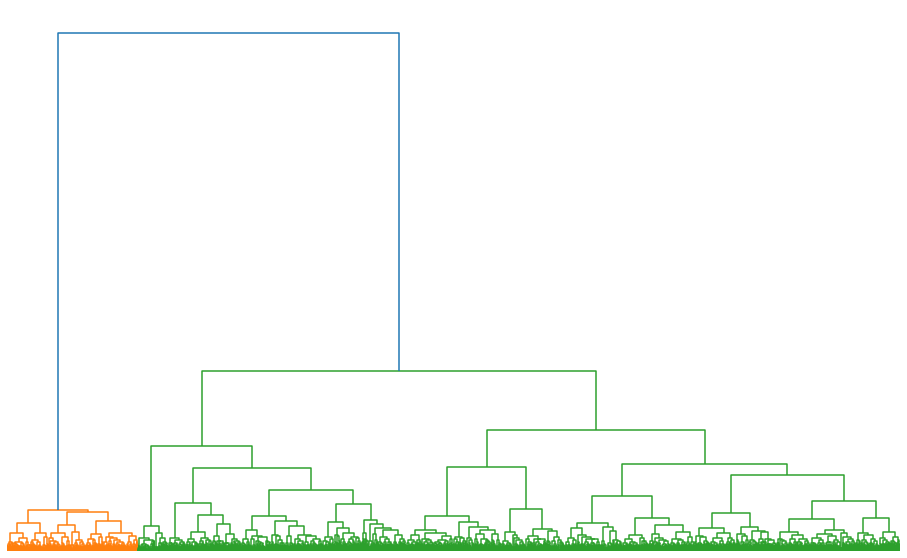

In [123]:
linked = linkage(w2v_enc, metric='euclidean', method='ward') 
plt.figure(figsize=(16, 10))  
dendrogram(linked, orientation='top')
plt.axis('off')
plt.show()

Дендрограмма выделяет только 3 кластера.

### Агломеративная кластеризация
Применим агломератиную кластеризация к набору усредненных эмбдингов с параметрами n_clusters=12 и косинусной мерой расстояния.

In [140]:
model_cos_w2v = AgglomerativeClustering(n_clusters=12, linkage='complete', affinity='cosine')
model_cos_w2v.fit(encoded_data)

AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=12)

In [141]:
df['cluster'] = model_cos_w2v.labels_

In [142]:
df.head()

,id,vacancy,company,experience,salary,url,description,skills,date,keyword,address,cluster
2196,44395934,Product Manager Trading,LATOKEN,6,390000.0,https://hh.ru/vacancy/44395934,LATOKEN’s mission is to put financial life at ...,"[Agile Project Management, Scrum, Финансовая о...",2021-05-06,data+analyst,"Москва, Космодамианская набережная, 52с1",5
2218,44395931,Product Manager Pitching,LATOKEN,6,150000.0,https://hh.ru/vacancy/44395931,LATOKEN’s mission is to put financial life at ...,"[Agile Project Management, Scrum, Финансовая о...",2021-05-06,data+analyst,"Москва, Космодамианская набережная, 52с1",5
2152,44395932,Product Manager Investment Platform,LATOKEN,6,NaN,https://hh.ru/vacancy/44395932,LATOKEN’s mission is to put financial life at ...,"[Agile Project Management, Scrum, Финансовая о...",2021-05-06,data+analyst,"Москва, Космодамианская набережная, 52с1",5
414,43897175,Ведущий продуктовый аналитик,Новакид РУС,3,200000.0,https://hh.ru/vacancy/43897175,Новакид приглашает ведущего продуктового анали...,"[Английский — B1 — Средний, SQL, Python, Googl...",2021-05-06,data+analyst,Москва,1
3495,44056137,Руководитель отдела Data Analysis,inDriver,6,NaN,https://hh.ru/vacancy/44056137,inDriver — международный сервис пассажирских п...,"[Python, SQL, Анализ данных, Управление командой]",2021-05-06,data+analyst,"Белорусская, Москва, 4-й Лесной переулок, 4",1


In [143]:
import pickle
model_pickle = open('cos_w2v_pickle', 'wb')
pickle.dump(model_cos_w2v, model_pickle)